# Task 1

## Task 1.1

In [14]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor

In [15]:
data = pd.read_csv('train_data.csv', index_col=0).reset_index().rename(columns={'index': 'id'})
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 400 non-null    int64  
 1   Age                400 non-null    float64
 2   Gender             400 non-null    int64  
 3   Stage              400 non-null    int64  
 4   GeneticRisk        315 non-null    float64
 5   TreatmentType      400 non-null    int64  
 6   ComorbidityIndex   355 non-null    float64
 7   TreatmentResponse  371 non-null    float64
 8   SurvivalTime       240 non-null    float64
 9   Censored           400 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 31.4 KB


,id,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
0,0,65.0,0,2,1.0,0,0.0,0.0,4.2,0
1,1,68.0,1,2,0.0,1,1.0,1.0,4.7,1
2,2,68.0,1,3,1.0,1,0.0,1.0,3.5,1
3,3,81.0,1,4,1.0,1,3.0,0.0,2.3,0
4,4,59.0,1,2,1.0,0,NaN,0.0,NaN,0


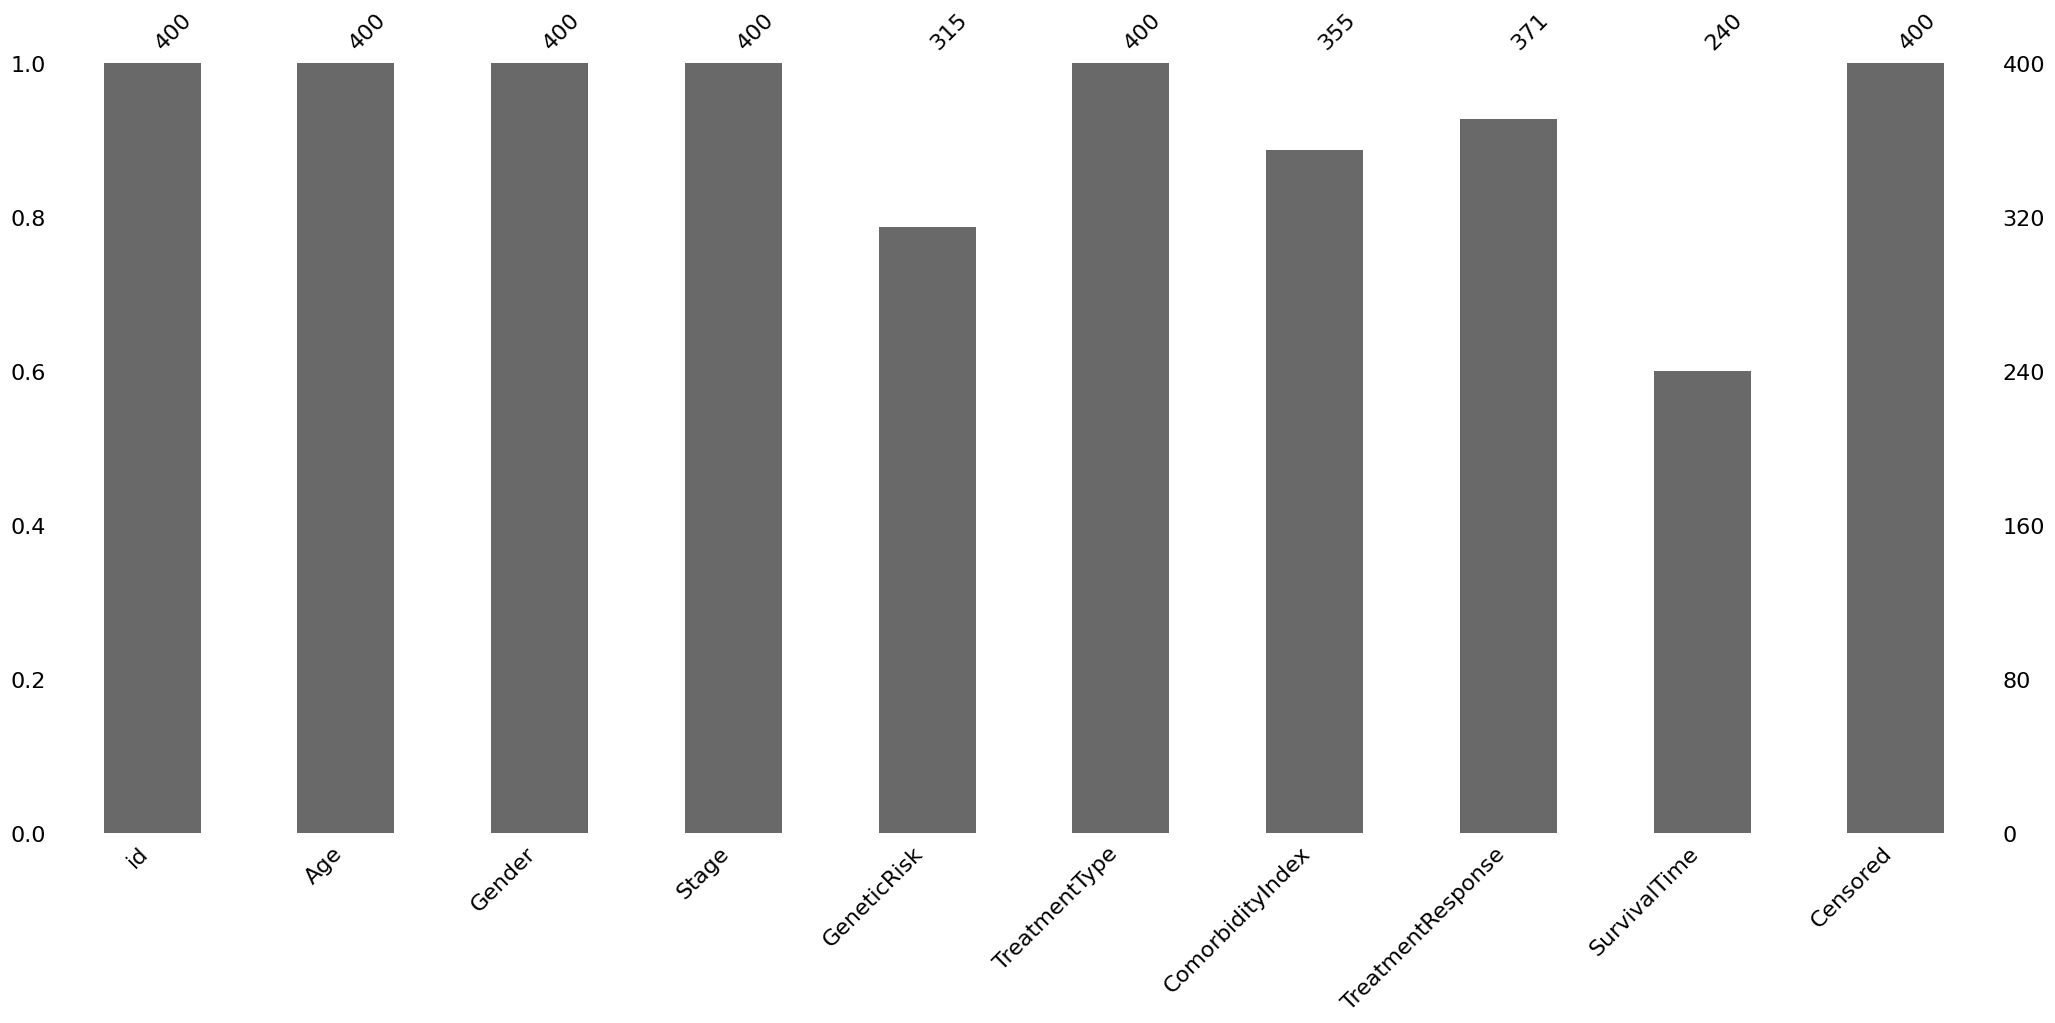

<Figure size 800x600 with 0 Axes>

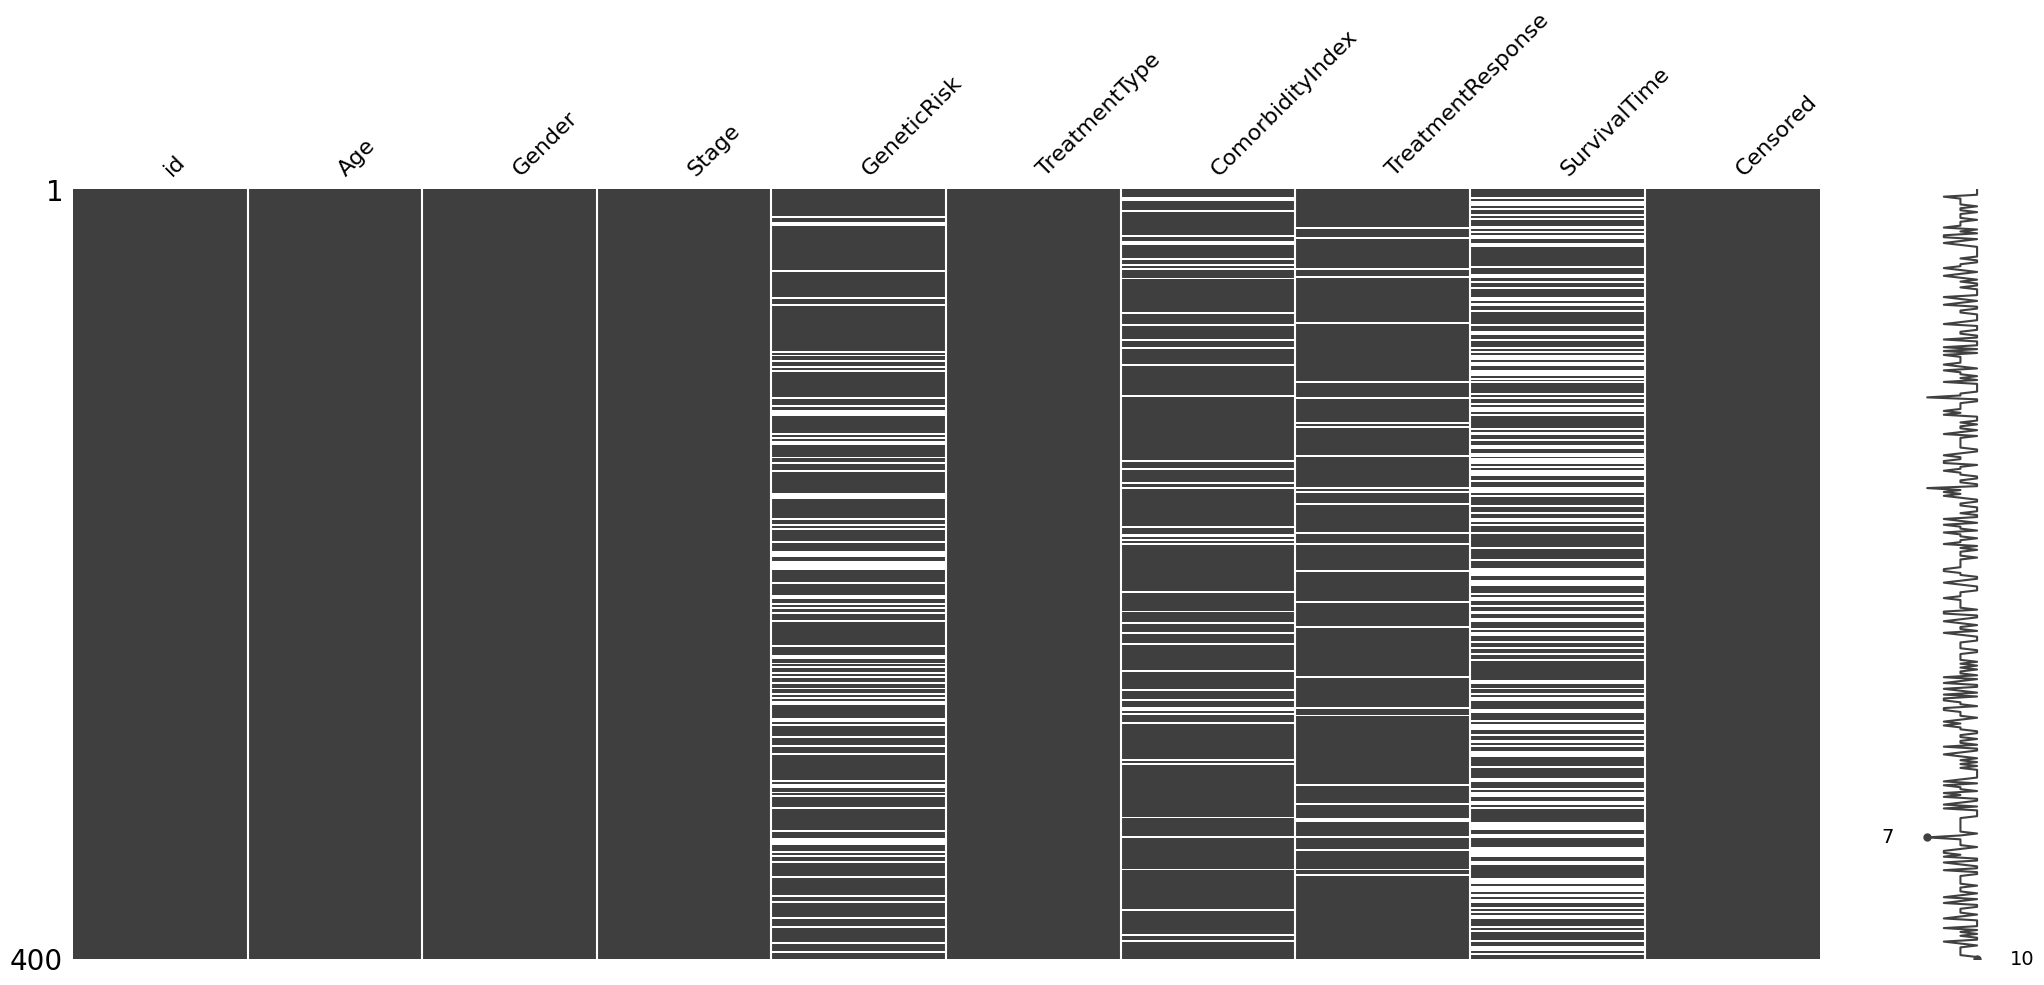

<Figure size 800x600 with 0 Axes>

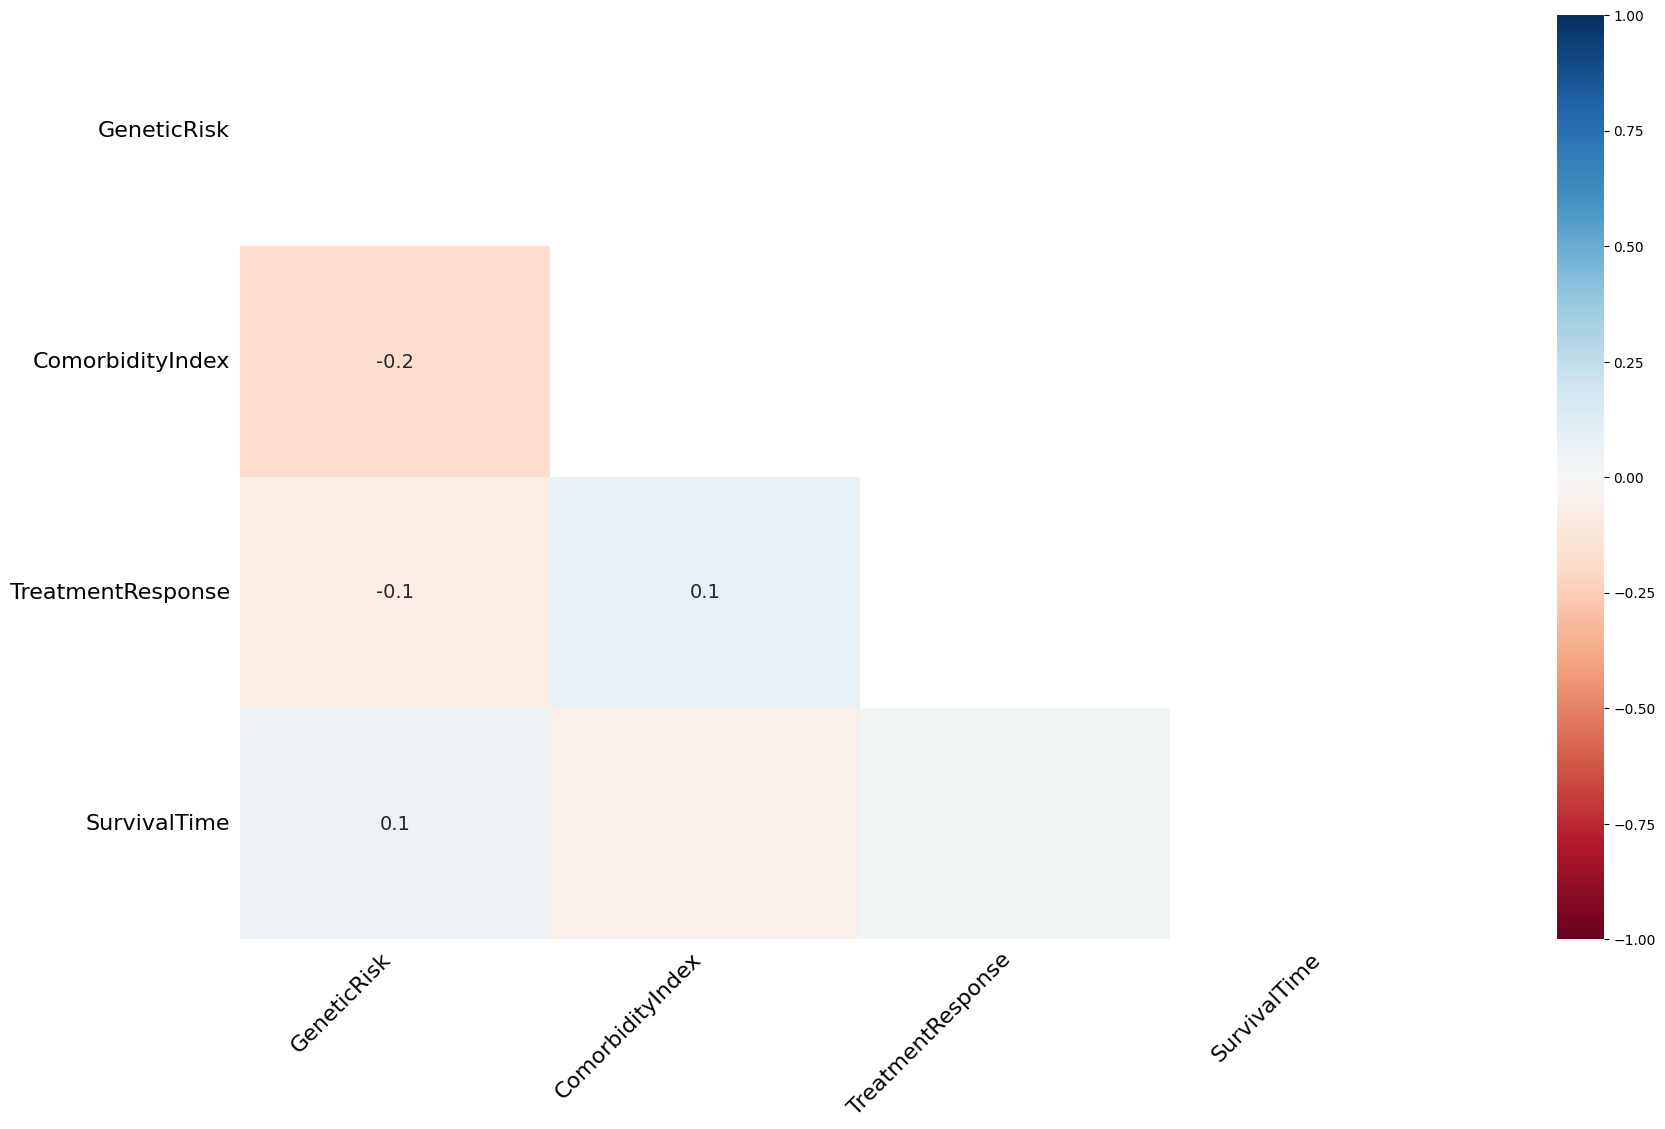

<Figure size 800x600 with 0 Axes>

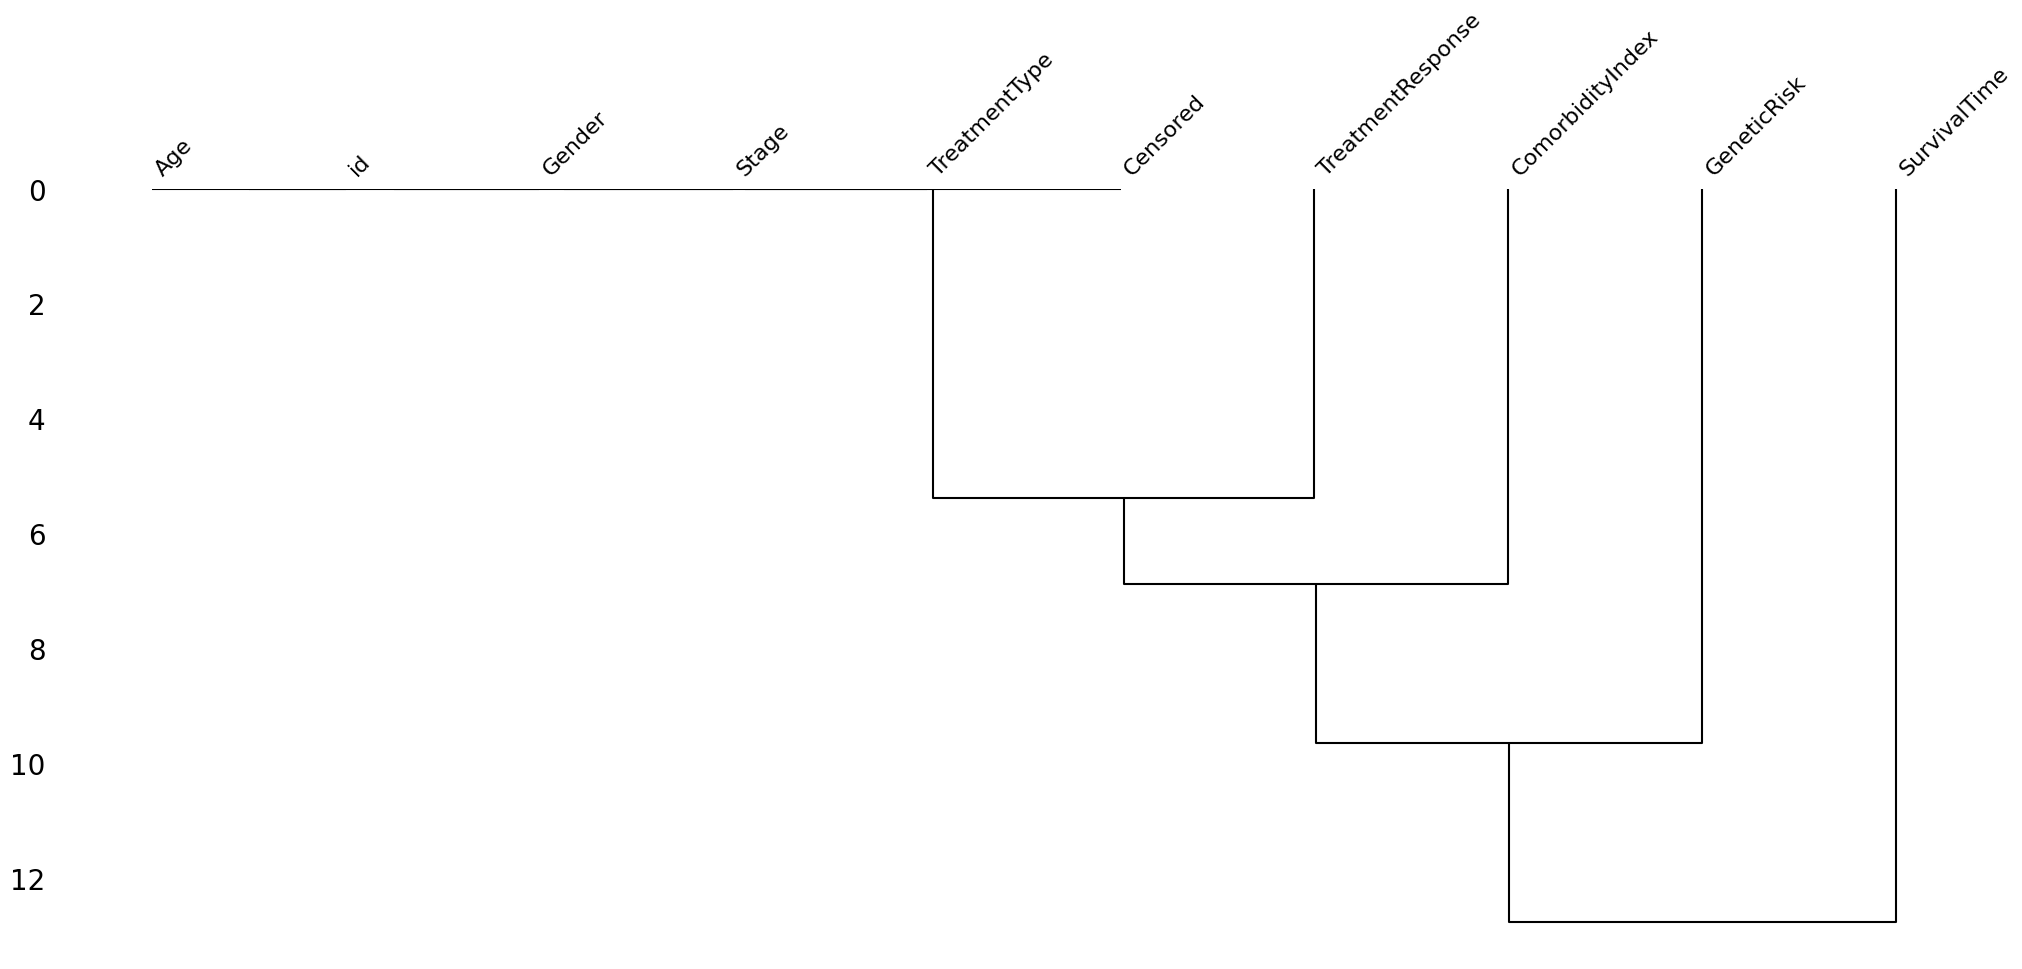

In [16]:
plt.figure(figsize=(8,4)); msno.bar(data); plt.show()
plt.figure(figsize=(8,6)); msno.matrix(data); plt.show()
plt.figure(figsize=(8,6)); msno.heatmap(data); plt.show()
plt.figure(figsize=(8,6)); msno.dendrogram(data); plt.show()

In [17]:
n_total = data.shape[0]
n_missing_surv = data['SurvivalTime'].isna().sum()
n_censored = data['Censored'].sum()  # 1 means censored in dataset
n_death_observed = ((data['Censored']==0) & data['SurvivalTime'].notna()).sum()
print(f"total={n_total}, missing_surv={n_missing_surv}, censored={n_censored}, observed_deaths={n_death_observed}")

total=400, missing_surv=160, censored=79, observed_deaths=161


#### Dataset summary

- Counts: total = 400; SurvivalTime non‑null = 240; censored = 79; observed deaths (uncensored with SurvivalTime) = 161.  
- Feature missingness: GeneticRisk (85 missing), ComorbidityIndex (45 missing), TreatmentResponse (29 missing). Dropping any row with a missing feature will reduce the 161 uncensored cases further; the complete‑case set is therefore likely much smaller than 161.

#### Observed correlations from missingno.heatmap:
- SurvivalTime — GeneticRisk: weak positive (≈ +0.1).  
- GeneticRisk — TreatmentResponse: weak negative (≈ −0.1).  
- GeneticRisk — ComorbidityIndex: weak negative (≈ −0.2).  
- ComorbidityIndex — TreatmentResponse: weak positive (≈ +0.1).  
- SurvivalTime — ComorbidityIndex / TreatmentResponse: essentially no correlation.

#### Practical interpretation
- The observed missingness correlations between GeneticRisk, ComorbidityIndex, TreatmentResponse and SurvivalTime are very small (≈ ±0.1–0.2). These numbers indicate negligible co‑occurrence of missingness — there are no large, clean blocks of rows we can remove without losing diverse information.
- Removing all rows with any missing feature (GeneticRisk: 85 missing; ComorbidityIndex: 45 missing; TreatmentResponse: 29 missing) together with censored rows (79) will therefore mainly reduce sample size rather than eliminate redundant problematic cases. This substantial loss of labeled data will hurt model fitting (higher variance, greater overfitting risk, and unstable validation).

In [18]:
features = ['Age','Gender','Stage','GeneticRisk','TreatmentType','ComorbidityIndex','TreatmentResponse']
missing_feat_cols = [col for col in features if data[col].isna().any()]
print("Feature columns with missing values:", missing_feat_cols)

data_dropcols = data.drop(columns=missing_feat_cols)
print("Columns after dropping features with missing values:", data_dropcols.columns.tolist())

filtered = data_dropcols.dropna(subset=['SurvivalTime']).copy()
filtered_uncensored = filtered[filtered['Censored'] == 0].copy()


display(filtered_uncensored.head())

Feature columns with missing values: ['GeneticRisk', 'ComorbidityIndex', 'TreatmentResponse']
Columns after dropping features with missing values: ['id', 'Age', 'Gender', 'Stage', 'TreatmentType', 'SurvivalTime', 'Censored']


,id,Age,Gender,Stage,TreatmentType,SurvivalTime,Censored
0,0,65.0,0,2,0,4.2,0
3,3,81.0,1,4,1,2.3,0
5,5,47.0,1,4,1,2.6,0
9,9,68.0,1,1,0,6.4,0
11,11,56.0,0,2,0,4.1,0


Remaining feature columns: ['Age', 'Gender', 'Stage', 'TreatmentType']


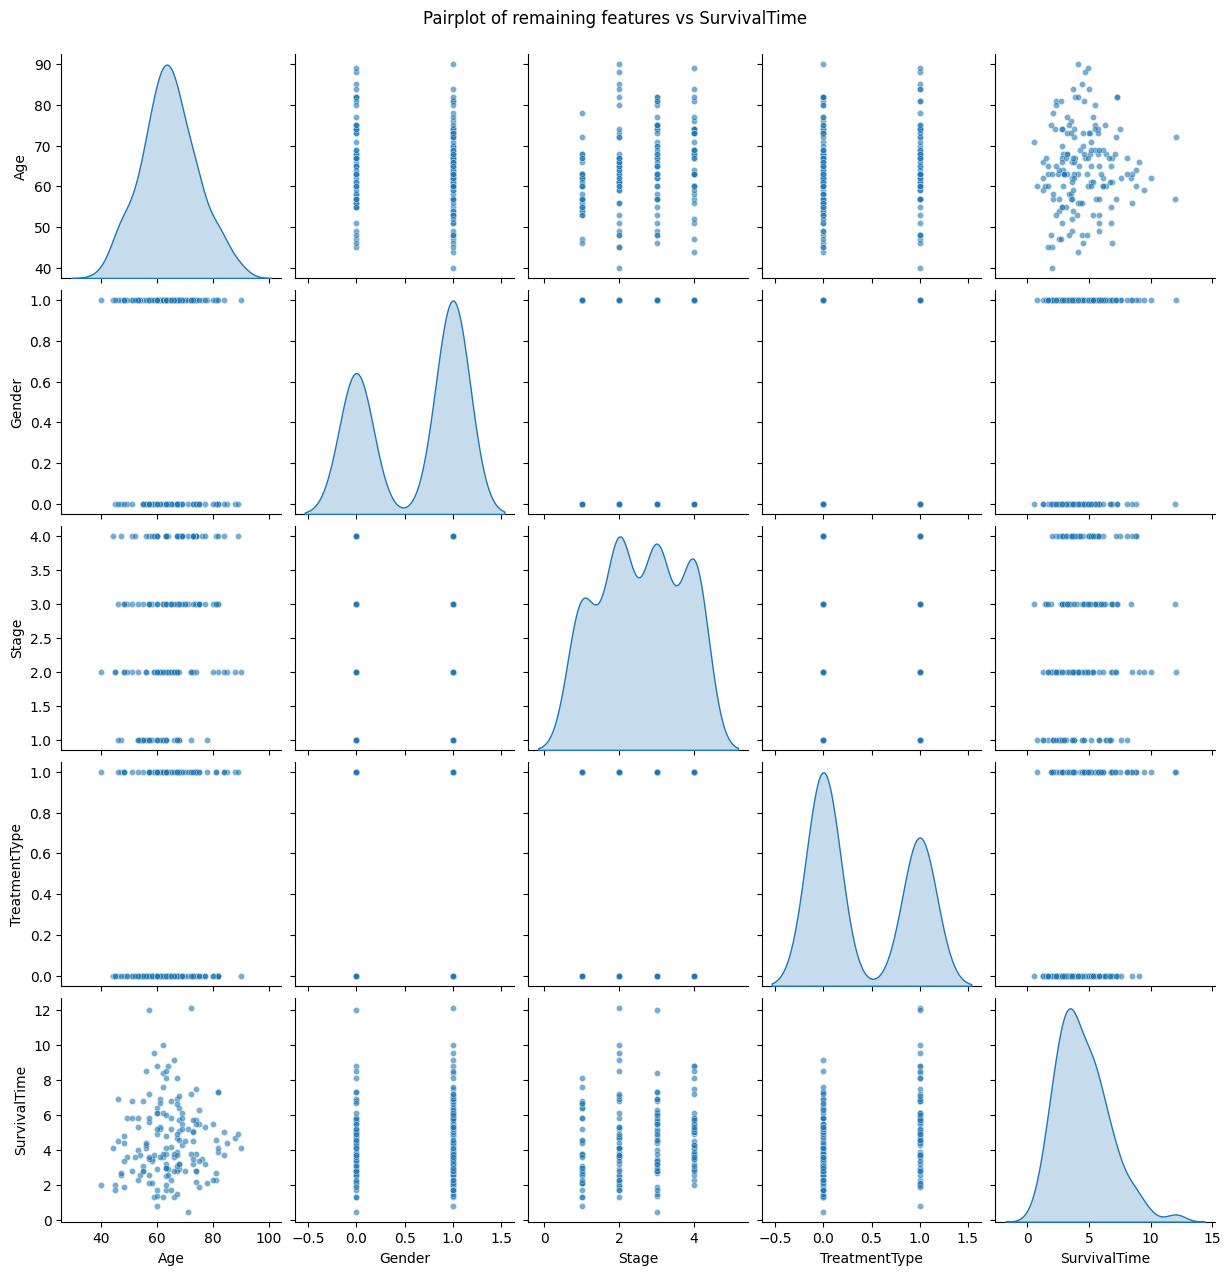

X shape: (161, 4)
y shape: (161,)


,Age,Gender,Stage,TreatmentType
0,65.0,0,2,0
3,81.0,1,4,1
5,47.0,1,4,1
9,68.0,1,1,0
11,56.0,0,2,0


In [19]:
feature_cols = [c for c in data_dropcols.columns if c not in ('id','SurvivalTime','Censored')]
print("Remaining feature columns:", feature_cols)

sns.pairplot(filtered_uncensored[feature_cols + ['SurvivalTime']], diag_kind='kde', plot_kws={'alpha':0.6, 's':20})
plt.suptitle('Pairplot of remaining features vs SurvivalTime', y=1.02)
plt.show()


X_df = filtered_uncensored[feature_cols].copy()
y = filtered_uncensored['SurvivalTime'].values
X = X_df.values

print("X shape:", X.shape)
print("y shape:", y.shape)
display(X_df.head())

#### Which validation procedure is more data‑efficient?
- Cross‑validation. With only 161 complete, uncensored rows (X shape = (161, 4)), a single train/validation/test split will reduce the amount of data available for training and produce high‑variance validation results. Example: a 70/15/15 split leaves ~113 training rows, ~24 validation rows — unstable for model selection.
- K‑fold CV reuses all labeled examples for both training and validation across folds, giving more stable, lower‑variance estimates of generalization and making maximal use of scarce labeled data. 

In [20]:
def error_metric(y, y_hat, c):
    err = y-y_hat
    err = (1-c)*err**2 + c*np.maximum(0,err)**2
    return np.sum(err)/err.shape[0]

## Task 1.2

CV cMSE (out of sample estimate of generalization error): 4.343603647166121
In-sample cMSE (training error): 4.087307290510991


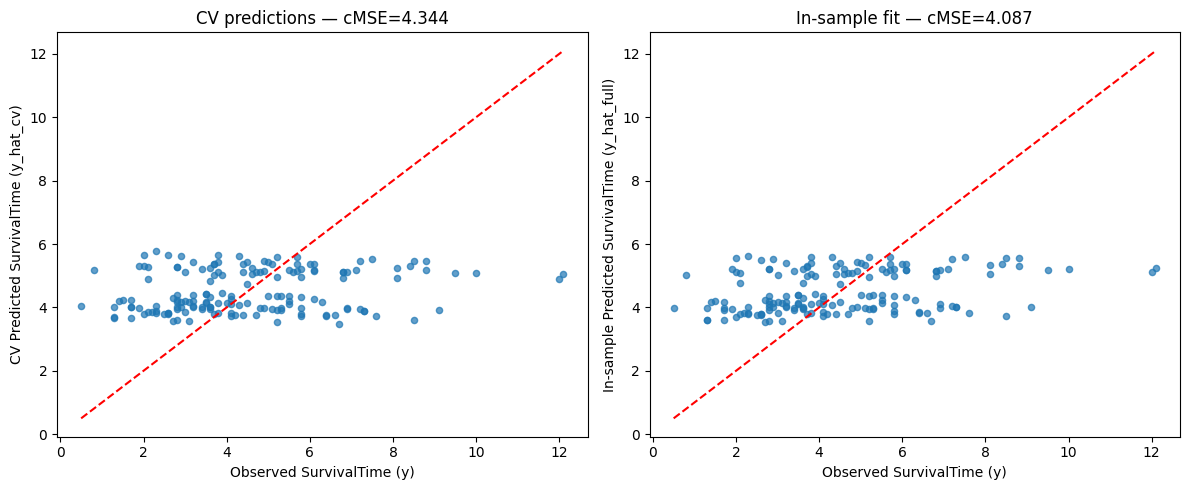

In [21]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

n_points = filtered_uncensored.shape[0]

cv = KFold(n_splits=n_points, shuffle=True, random_state=0)

y_pred_cv = cross_val_predict(pipeline, X, y, cv=cv)

c = filtered_uncensored['Censored'].values

# compute cMSE (equivalent to MSE here because c==0)
cmse_cv = error_metric(y, y_pred_cv, c)
print("CV cMSE (out of sample estimate of generalization error):", cmse_cv)

pipeline.fit(X, y)
y_pred_full = pipeline.predict(X)
cmse_full = error_metric(y, y_pred_full, c)
print("In-sample cMSE (training error):", cmse_full)

# y vs y_hat plots
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y, y_pred_cv, alpha=0.7, s=20)
maxv = max(y.max(), y_pred_cv.max())
minv = min(y.min(), y_pred_cv.min())
plt.plot([minv, maxv], [minv, maxv], 'r--')
plt.xlabel('Observed SurvivalTime (y)')
plt.ylabel('CV Predicted SurvivalTime (y_hat_cv)')
plt.title(f'CV predictions — cMSE={cmse_cv:.3f}')

plt.subplot(1,2,2)
plt.scatter(y, y_pred_full, alpha=0.7, s=20)
maxv = max(y.max(), y_pred_full.max())
minv = min(y.min(), y_pred_full.min())
plt.plot([minv, maxv], [minv, maxv], 'r--')
plt.xlabel('Observed SurvivalTime (y)')
plt.ylabel('In-sample Predicted SurvivalTime (y_hat_full)')
plt.title(f'In-sample fit — cMSE={cmse_full:.3f}')

plt.tight_layout()
plt.show()



In [22]:
test = pd.read_csv('test_data.csv')

cols_to_drop = [c for c in missing_feat_cols if c in test.columns]
test_drop = test.drop(columns=cols_to_drop)

X_test = test_drop[feature_cols].values

y_test_pred = pipeline.predict(X_test)

submission = pd.DataFrame({
    'id': test_drop['id'].values,
    '0': y_test_pred
})


submission.to_csv('baseline-submission-01.csv', index=False)
print("Saved baseline-submission-01.csv:")
display(submission.head())

Saved baseline-submission-01.csv:


,id,0
0,0,5.588019
1,1,4.321626
2,2,3.782002
3,3,5.194959
4,4,4.305387


# Task 2. Nonlinear Models

## Task 2.1 Development

In [23]:
def select_polynomial_degree(X, y, c, cv, degrees=range(1,10), verbose=True):
    print("--- Tuning Polynomial Regression (Degree) ---")
    degrees = list(degrees)
    results = {}
    for d in degrees:
        pipe = Pipeline([
            ('poly', PolynomialFeatures(degree=d, include_bias=False)),
            ('scaler', StandardScaler()),
            ('lr', LinearRegression())
        ])
        y_pred_cv = cross_val_predict(pipe, X, y, cv=cv)
        cmse = error_metric(y, y_pred_cv, c)
        results[d] = cmse
        if verbose:
            print(f"degree={d}: CV cMSE={cmse:.6f}")
    best = min(results, key=results.get)
    if verbose:
        print(f"Selected degree={best} (CV cMSE={results[best]:.6f})\n")
    return best, results


In [24]:
def select_k_knn(X, y, c, cv, ks=range(1,16), verbose=True):
    print("--- Tuning k-Nearest Neighbors (k) ---")
    ks = list(ks)  
    results = {}
    for k in ks:
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsRegressor(n_neighbors=k))
        ])
        y_pred_cv = cross_val_predict(pipe, X, y, cv=cv)
        cmse = error_metric(y, y_pred_cv, c)
        results[k] = cmse
        if verbose:
            print(f"k={k}: CV cMSE={cmse:.6f}")
    best = min(results, key=results.get)
    if verbose:
        print(f"Selected k={best} (CV cMSE={results[best]:.6f})\n")
    return best, results

In [26]:
degrees_to_test = range(1, 10)
best_degree, poly_results = select_polynomial_degree(X, y, c, cv, degrees=degrees_to_test)

--- Tuning Polynomial Regression (Degree) ---
degree=1: CV cMSE=4.343604
degree=2: CV cMSE=4.500093
degree=3: CV cMSE=4.978758
degree=4: CV cMSE=6.795851
degree=5: CV cMSE=67.640316
degree=6: CV cMSE=330.681405
degree=7: CV cMSE=78805.483400
degree=8: CV cMSE=722509.947661
degree=9: CV cMSE=6828011182.652889
Selected degree=1 (CV cMSE=4.343604)



In [27]:
ks_to_test = range(1, 21)
best_k, knn_results = select_k_knn(X, y, c, cv, ks=ks_to_test)

--- Tuning k-Nearest Neighbors (k) ---
k=1: CV cMSE=6.588509
k=2: CV cMSE=5.524410
k=3: CV cMSE=5.144306
k=4: CV cMSE=5.326370
k=5: CV cMSE=4.919732
k=6: CV cMSE=4.775122
k=7: CV cMSE=4.698067
k=8: CV cMSE=4.707557
k=9: CV cMSE=4.524885
k=10: CV cMSE=4.456504
k=11: CV cMSE=4.353340
k=12: CV cMSE=4.319730
k=13: CV cMSE=4.273182
k=14: CV cMSE=4.295379
k=15: CV cMSE=4.278133
k=16: CV cMSE=4.218996
k=17: CV cMSE=4.259273
k=18: CV cMSE=4.268692
k=19: CV cMSE=4.298373
k=20: CV cMSE=4.333765
Selected k=16 (CV cMSE=4.218996)



## Task 2.2

In [29]:

print("--- Model Evaluation ---")

# 1. Baseline Model (from Task 1.2)
pipe_lr = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
y_pred_lr = cross_val_predict(pipe_lr, X, y, cv=cv)
cmse_lr = error_metric(y, y_pred_lr, c) # This was 4.3436 in Task 1.2
err_lr = y - y_pred_lr

# 2. Best Polynomial Model (using best_degree found)
pipe_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])
y_pred_poly = cross_val_predict(pipe_poly, X, y, cv=cv)
cmse_poly = error_metric(y, y_pred_poly, c)
err_poly = y - y_pred_poly

# 3. Best k-NN Model (using best_k found)
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=best_k))
])
y_pred_knn = cross_val_predict(pipe_knn, X, y, cv=cv)
cmse_knn = error_metric(y, y_pred_knn, c)
err_knn = y - y_pred_knn

# Create comparison table data
eval_data = {
    'Model': ['Baseline (LinReg)', f'Polynomial (d={best_degree})', f'k-NN (k={best_k})'],
    'CV cMSE (Mean Error)': [cmse_lr, cmse_poly, cmse_knn],
    'Error Max': [np.max(err_lr), np.max(err_poly), np.max(err_knn)],
    'Error Min': [np.min(err_lr), np.min(err_poly), np.min(err_knn)],
    'Error Std Dev': [np.std(err_lr), np.std(err_poly), np.std(err_knn)]
}
eval_df = pd.DataFrame(eval_data)
print(eval_df.to_markdown(index=False, floatfmt='.4f'))
print("\n")


--- Model Evaluation ---
| Model             |   CV cMSE (Mean Error) |   Error Max |   Error Min |   Error Std Dev |
|:------------------|-----------------------:|------------:|------------:|----------------:|
| Baseline (LinReg) |                 4.3436 |      7.0890 |     -4.3714 |          2.0841 |
| Polynomial (d=1)  |                 4.3436 |      7.0890 |     -4.3714 |          2.0841 |
| k-NN (k=16)       |                 4.2190 |      6.7937 |     -5.3625 |          2.0531 |




In [32]:
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=best_k))
])
knn_pipe.fit(X, y)

test = pd.read_csv('test_data.csv')
cols_to_drop = [col for col in missing_feat_cols if col in test.columns]
test_drop = test.drop(columns=cols_to_drop)
X_test = test_drop[feature_cols].values

y_test_pred = knn_pipe.predict(X_test)

submission_knn = pd.DataFrame({
    'id': test_drop['id'].values,
    '0': y_test_pred
})
submission_knn.to_csv('knn-submission-03.csv', index=False)
print("Saved knn-submission-03.csv")



Saved knn-submission-03.csv
